# Brownian Motion

In [1]:
using Pkg; Pkg.activate()
using KadanoffBaym
using LinearAlgebra

using PyPlot
PyPlot.plt.style.use("./paper.mplstyle")
using LaTeXStrings

  Activating project at `~/.julia/environments/v1.10`


In [2]:
# wrapper function for the KB solver
function solution(N₀::Float64, D::Float64; args...)
    
    # analytical solution
    function F_ana(t1, t2)
        return (F[1, 1] - D/(2 * theta)) * exp(-theta * (t1 + t2)) + D/(2 * theta) * exp(-theta * abs(t1 - t2))
    end
    
    # right-hand side for the "vertical" evolution
    function fv!(out, _, _, _, t1, t2)
        out[1] = -theta * F[t1, t2]
    end
    
    # right-hand side for the "diagonal" evolution
    function fd!(out, _, _, _, t1, t2)
        out[1] = -theta * 2F[t1, t2] + D
    end
    
    F = GreenFunction(N₀ * ones(1,1), Symmetrical)
    
    sol = kbsolve!(fv!, fd!, [F], (0.0, T); args...)

    return [sol.t, F.data, [F_ana(t1, t2) for t1 in sol.t, t2 in sol.t]]
end;

In [3]:
# final time
T = 4.0

# drift
theta = 1.

# time-scale
t_scale = (iszero(theta) ? one(theta) : abs(theta))

# different initial values
N₀ = [1., 3., 5.]

# different diffusion strengths
Ds = [8., 4., 1.]

s = mapreduce((x...) -> solution(x...; atol=1e-9, rtol=1e-7, dtini=1e-10), hcat, N₀, Ds);

## Plotting

In [4]:
cmap = "gist_heat";
colors = ["C0", "C3", "C2"];
lss = ["-", "--", "-."];

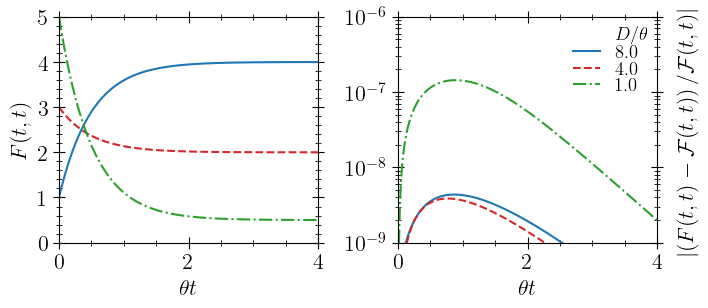

In [5]:
fig = figure(figsize=(7, 3))

ax = subplot(121)
for k in eachindex(N₀)
    plot(s[1,k], diag(s[2,k]), label="\$xxx\$", lw=1.5, c=colors[k], ls=lss[k])
end
ax.set_xlim(0, theta * T)
ax.set_ylim(0, 1.1 * Ds[1]/(2theta))
ax.set_yticks([0, 1, 2, 3, 4, 5])
ax.set_xlabel(L"\theta t")
ax.set_ylabel(L"F(t, t)")#, pad=15)

ax = subplot(122)
plot([], [], label=L"D/\theta", c="w")
for k in eachindex(N₀)
    semilogy(s[1,k], abs.((diag(s[2,k])  .- diag(s[3,k])) ./ diag(s[3,k])), lw=1.5, c=colors[k], label=L"%$(string(Ds[k]/(theta)))", ls=lss[k])
end

ax.set_xlim(0, theta * T)
ax.set_ylim(1e-9, 1e-6)
ax.set_xlabel(L"\theta t")
ax.set_ylabel(L"\left|\left(F(t,t) - \mathcal{F}(t,t)\right) / \mathcal{F}(t,t)\right|", labelpad=10)
ax.yaxis.set_label_position("right")

ax.legend(loc="best", frameon=false, labelspacing=0.0, borderpad=0, handlelength=1.5, fontsize="small")
tight_layout(pad=0.25, w_pad=1, h_pad=0)

# savefig("brownian_motion_example_1.pdf")

## 2D plot

In [6]:
function meshgrid(xin,yin)
  nx=length(xin)
  ny=length(yin)
  xout=zeros(ny,nx)
  yout=zeros(ny,nx)
  for jx=1:nx
      for ix=1:ny
          xout[ix,jx]=xin[jx]
          yout[ix,jx]=yin[ix]
      end
  end
  return (x=xout, y=yout)
end

meshgrid (generic function with 1 method)

In [7]:
Y, X = meshgrid(s[1,1], s[1,1]);

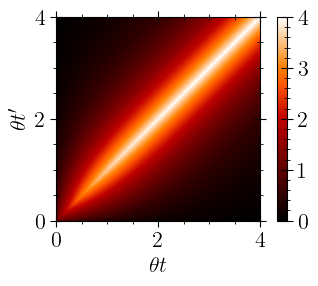

In [8]:
figure(figsize=(4, 3))

vmin = 0
vmax = Ds[1]/(2theta)
ax = subplot(111)
heatmap = ax.pcolormesh(t_scale * X, t_scale * Y, s[2,1], cmap=cmap, rasterized=true, vmin=vmin, vmax=vmax)
heatmap.set_edgecolor("face")
ax.set_aspect("equal")
cbar = colorbar(mappable=heatmap)
cbar.formatter.set_powerlimits((0, 0))
ax.set_xlabel(L"\theta t")
ax.set_ylabel(L"\theta t^\prime")
ax.set_xlim(0, t_scale * T)
ax.set_ylim(0, t_scale * T)
ax.set_xticks(t_scale .* [0, T/2, T])
ax.set_yticks(t_scale .* [0, T/2, T])


tight_layout(pad=0.75, w_pad=0.25, h_pad=0)
# savefig("brownian_motion_example_2.pdf")